# K-Neirest-Neighbors of star

Define path where stars files are located, and save their filenames in array.

In [11]:
from os import listdir
from os.path import isfile, join
import time
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import Angle
import numpy as np
import pandas as pd 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

Format the data file

In [30]:
import re
fw = open('/home/andrea/Escritorio/Varstar/data.csv', 'w')
i = 0
with open('/home/andrea/Escritorio/Varstar/ACVS.1.1', 'r') as f:
    for line in f:
        if i == 0:
            i=i+1
            continue
        elif i == 1:
            l = 'ID,PER,HJD0,VMAX,VAMP,TYPE,GCVS_ID,GCVS_TYPE,IR12,IR25,IR60,IR100,J,H,K,V_IR12,V_J,V_H,V_K,J_H,H_K\n'
            fw.write(l)
            i=i+1
            continue
        l = re.sub(' +', ',',line)
        fw.write(l)

In [31]:
data = pd.read_csv("/home/andrea/Escritorio/Varstar/data.csv") 
data.head()

,ID,PER,HJD0,VMAX,VAMP,TYPE,GCVS_ID,GCVS_TYPE,IR12,IR25,...,IR100,J,H,K,V_IR12,V_J,V_H,V_K,J_H,H_K
0,000006+2553.2,313.963337,0.00,8.56,4.05,MIRA,Z~Peg,M,-4.33,-3.38,...,-0.63,2.23,1.32,0.92,12.89,6.33,7.24,7.64,0.91,0.40
1,000007+1844.3,2.588900,2627.14,10.85,0.09,ESD/CW-FU/ACV/ED,DM~Peg,EA/D:,6.00,6.00,...,6.00,10.11,9.95,9.89,99.99,0.74,0.90,0.96,0.16,0.06
2,000007+2014.3,55.593929,0.00,9.07,0.85,MISC,EP~Peg,SR,-2.11,-1.09,...,0.00,4.03,3.08,2.56,11.17,5.04,5.99,6.51,0.95,0.52
3,000017+2636.4,381.698104,0.00,10.83,2.29,MIRA,AH~Peg,SRB,-0.34,0.64,...,0.00,7.35,6.54,6.18,11.17,3.48,4.29,4.65,0.81,0.36
4,000018+0919.4,43.068177,2023.40,10.52,0.11,MISC,-,-,6.00,6.00,...,6.00,8.55,8.04,7.94,99.99,1.97,2.48,2.58,0.51,0.10


## Scikit-Learn

Save coordinates (SkyCoord) of each star in array, for radec later use.

In [32]:
radec = []
for f in data['ID']:
    cra = Angle(f[0:2]+'h'+f[2:4]+'m'+f[4:6]+'s')
    cdec = Angle(f[6:9]+'d'+f[9:11]+'m')
    radec.append([cra.arcsecond, cdec.arcsecond])

Scikit Learn consideres the self star as it's most nearest neighbor, so if we want to perform an all-in-all analysis, we'll have to declare n_neighbots=n+1, where n is the total quantity of stars.

In [33]:
def knn(n):
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='auto', metric='euclidean').fit(radec)
    _, indices = nbrs.kneighbors(radec)
    return indices[:,1:]

## Execution Times

Repeat the function for different n.

In [34]:
times = []
ne = []

for i in range(1,200,10):
    ne.append(i)
    start_time = time.time()
    knn(i)
    end_time = time.time()
    times.append(end_time - start_time)

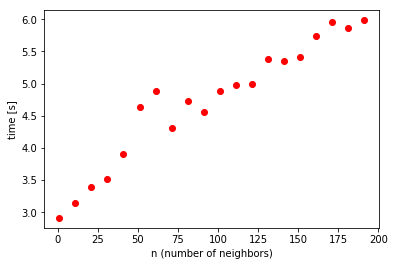

In [35]:
plt.plot(ne, times, 'ro')
plt.xlabel('n (number of neighbors)')
plt.ylabel('time [s]')
plt.show()

In [36]:
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(ne, times)
f = lambda x: slope*x + intercept

other_ne = np.linspace(0, 1000, 50)
other_times = f(other_ne)

trace1 = go.Scatter(
    x=ne,
    y=times,
    mode='markers',
    name='Data',
    marker=dict(
        size=12
    )
)

trace2 = go.Scatter(
    x=other_ne,
    y=other_times,
    mode='lines',
    name='Fit'
)

layout = go.Layout(
    title='Lineal Fit in Python',
    xaxis=dict(
        title='neirest neighbors',
    ),
    yaxis=dict(
        title='time (s)',
    )
)

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='interpolation-and-extrapolation')

To do:
dynamic plot for different star observed (N) and different neighborhood sizes (K).

In [64]:
# Debo tomar las coordenadas de la estrella N (radec[N]) y las coordenadas de las K estrellas vecinas.